# Risk Contributions and Risk Parity

> The word 'risk' derives from the early Italian risicare, which means 'to dare'. In this sense, risk is a choice rather than a fate. The actions we dare to take, which depend on how free we are to make choices, are what the story of risk is all about.

_Peter L. Bernstein, Against the Gods: The Remarkable Story of Risk_

In [38]:
import numpy as np
import pandas as pd

import edhec_risk_kit_206 as erk

%load_ext autoreload
%autoreload 2
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
#inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["2014":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["2014":]
inds = ind_rets.columns.to_list()

rets = ind_rets["2014":][inds]
cov = rets.cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = erk.portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

In [43]:
erk.weight_cw(rets, ind_mcap[inds]).sort_values().tail()

Rtail    0.064583
Oil      0.073174
Drugs    0.086847
Banks    0.087787
Softw    0.100182
Name: 2014-02, dtype: float64

In [45]:
round(risk_contribution(erk.weight_cw(rets, ind_mcap[inds]), cov)*100, 2).sort_values().tail()

Rtail     6.72
Oil       8.52
Drugs     8.91
Softw     9.84
Banks    10.40
dtype: float64

In [46]:
erk.weight_ew(rets)

Agric    0.020408
Food     0.020408
Soda     0.020408
Beer     0.020408
Smoke    0.020408
Toys     0.020408
Fun      0.020408
Books    0.020408
Hshld    0.020408
Clths    0.020408
Hlth     0.020408
MedEq    0.020408
Drugs    0.020408
Chems    0.020408
Rubbr    0.020408
Txtls    0.020408
BldMt    0.020408
Cnstr    0.020408
Steel    0.020408
FabPr    0.020408
Mach     0.020408
ElcEq    0.020408
Autos    0.020408
Aero     0.020408
Ships    0.020408
Guns     0.020408
Gold     0.020408
Mines    0.020408
Coal     0.020408
Oil      0.020408
Util     0.020408
Telcm    0.020408
PerSv    0.020408
BusSv    0.020408
Hardw    0.020408
Softw    0.020408
Chips    0.020408
LabEq    0.020408
Paper    0.020408
Boxes    0.020408
Trans    0.020408
Whlsl    0.020408
Rtail    0.020408
Meals    0.020408
Banks    0.020408
Insur    0.020408
RlEst    0.020408
Fin      0.020408
Other    0.020408
dtype: float64

In [48]:
round(risk_contribution(erk.weight_ew(rets), cov)*100,2).sort_values().tail()

BldMt    2.81
Mines    2.86
Coal     2.90
Ships    3.00
Steel    3.09
dtype: float64

In [49]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)


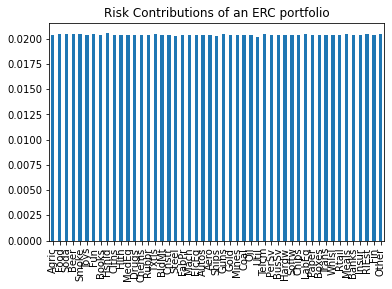

In [50]:
risk_contribution(equal_risk_contributions(cov), cov).plot.bar(title="Risk Contributions of an ERC portfolio");

In [51]:
def weight_erc(r, cov_estimator=erk.sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)


In [55]:
pd.Series((100*weight_erc(ind_rets[inds])).round(2), index=inds).sort_values().tail()

Food     3.03
Beer     3.20
Smoke    3.26
Hshld    3.32
Util     5.22
dtype: float64

In [54]:
pd.Series((100*weight_erc(ind_rets[inds])).round(2), index=inds).sort_values().head()

Steel    1.28
Ships    1.30
BldMt    1.38
Mines    1.40
Mach     1.43
dtype: float64

In [57]:
pd.Series((100*weight_erc(ind_rets[inds])).round(2), index=inds).sort_values().tail(1).values - pd.Series((100*weight_erc(ind_rets[inds])).round(2), index=inds).sort_values().head(1).values

array([3.94])

In [63]:
(risk_contribution(equal_risk_contributions(cov), cov).sort_values()[[0, -1]]*100).round(2)

Util     2.02
Hshld    2.05
dtype: float64

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117007,0.149311,-0.702445,5.458192,0.066685,0.096232,0.566996,-0.518076


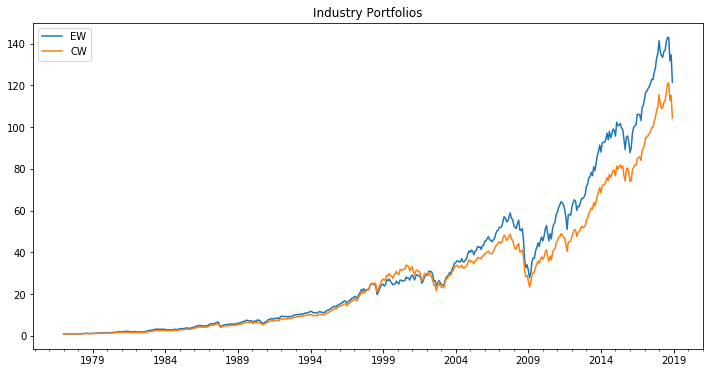

In [7]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Now, let's run a backtest of this new weighting scheme we've just developed. Be warned that this will likely take quite some time to run - depending on your computer's CPU horsepower, but on my laptop it took several minutes.

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117007,0.149311,-0.702445,5.458192,0.066685,0.096232,0.566996,-0.518076
ERC-Sample,0.120185,0.149185,-0.872577,7.019237,0.066886,0.096357,0.588203,-0.502950


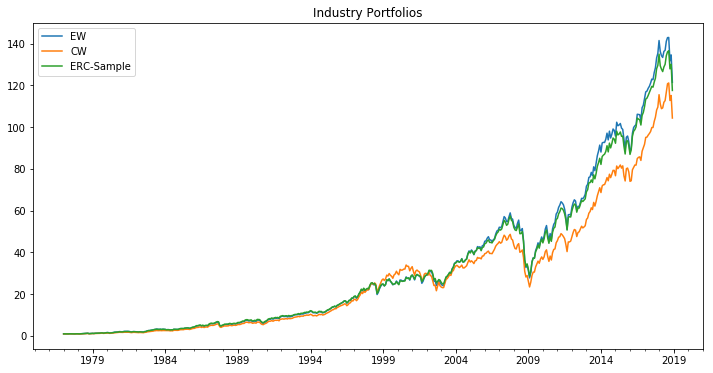

In [8]:
mv_erc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_erc, cov_estimator=erk.sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "ERC-Sample": mv_erc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())